In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})
from dask.distributed import Client

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [2]:
 # magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

## Catalogs

In [3]:
%%time
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 34.9 s, sys: 7.8 s, total: 42.7 s
Wall time: 43.8 s


In [11]:
%%time
star_horse = dask.dataframe.read_parquet("/epyc/ssd/users/atzanida/tmp/starH24/StarHorseFGK.parquet", engine='pyarrow')
star_horse = star_horse.compute()

CPU times: user 26.3 s, sys: 6min 5s, total: 6min 31s
Wall time: 30.5 s


In [14]:
print (f"Number of STARHORSE FGK stars: {len(star_horse)}")

Number of STARHORSE FGK stars: 106866623


Text(0, 0.5, 'Dec [deg]')

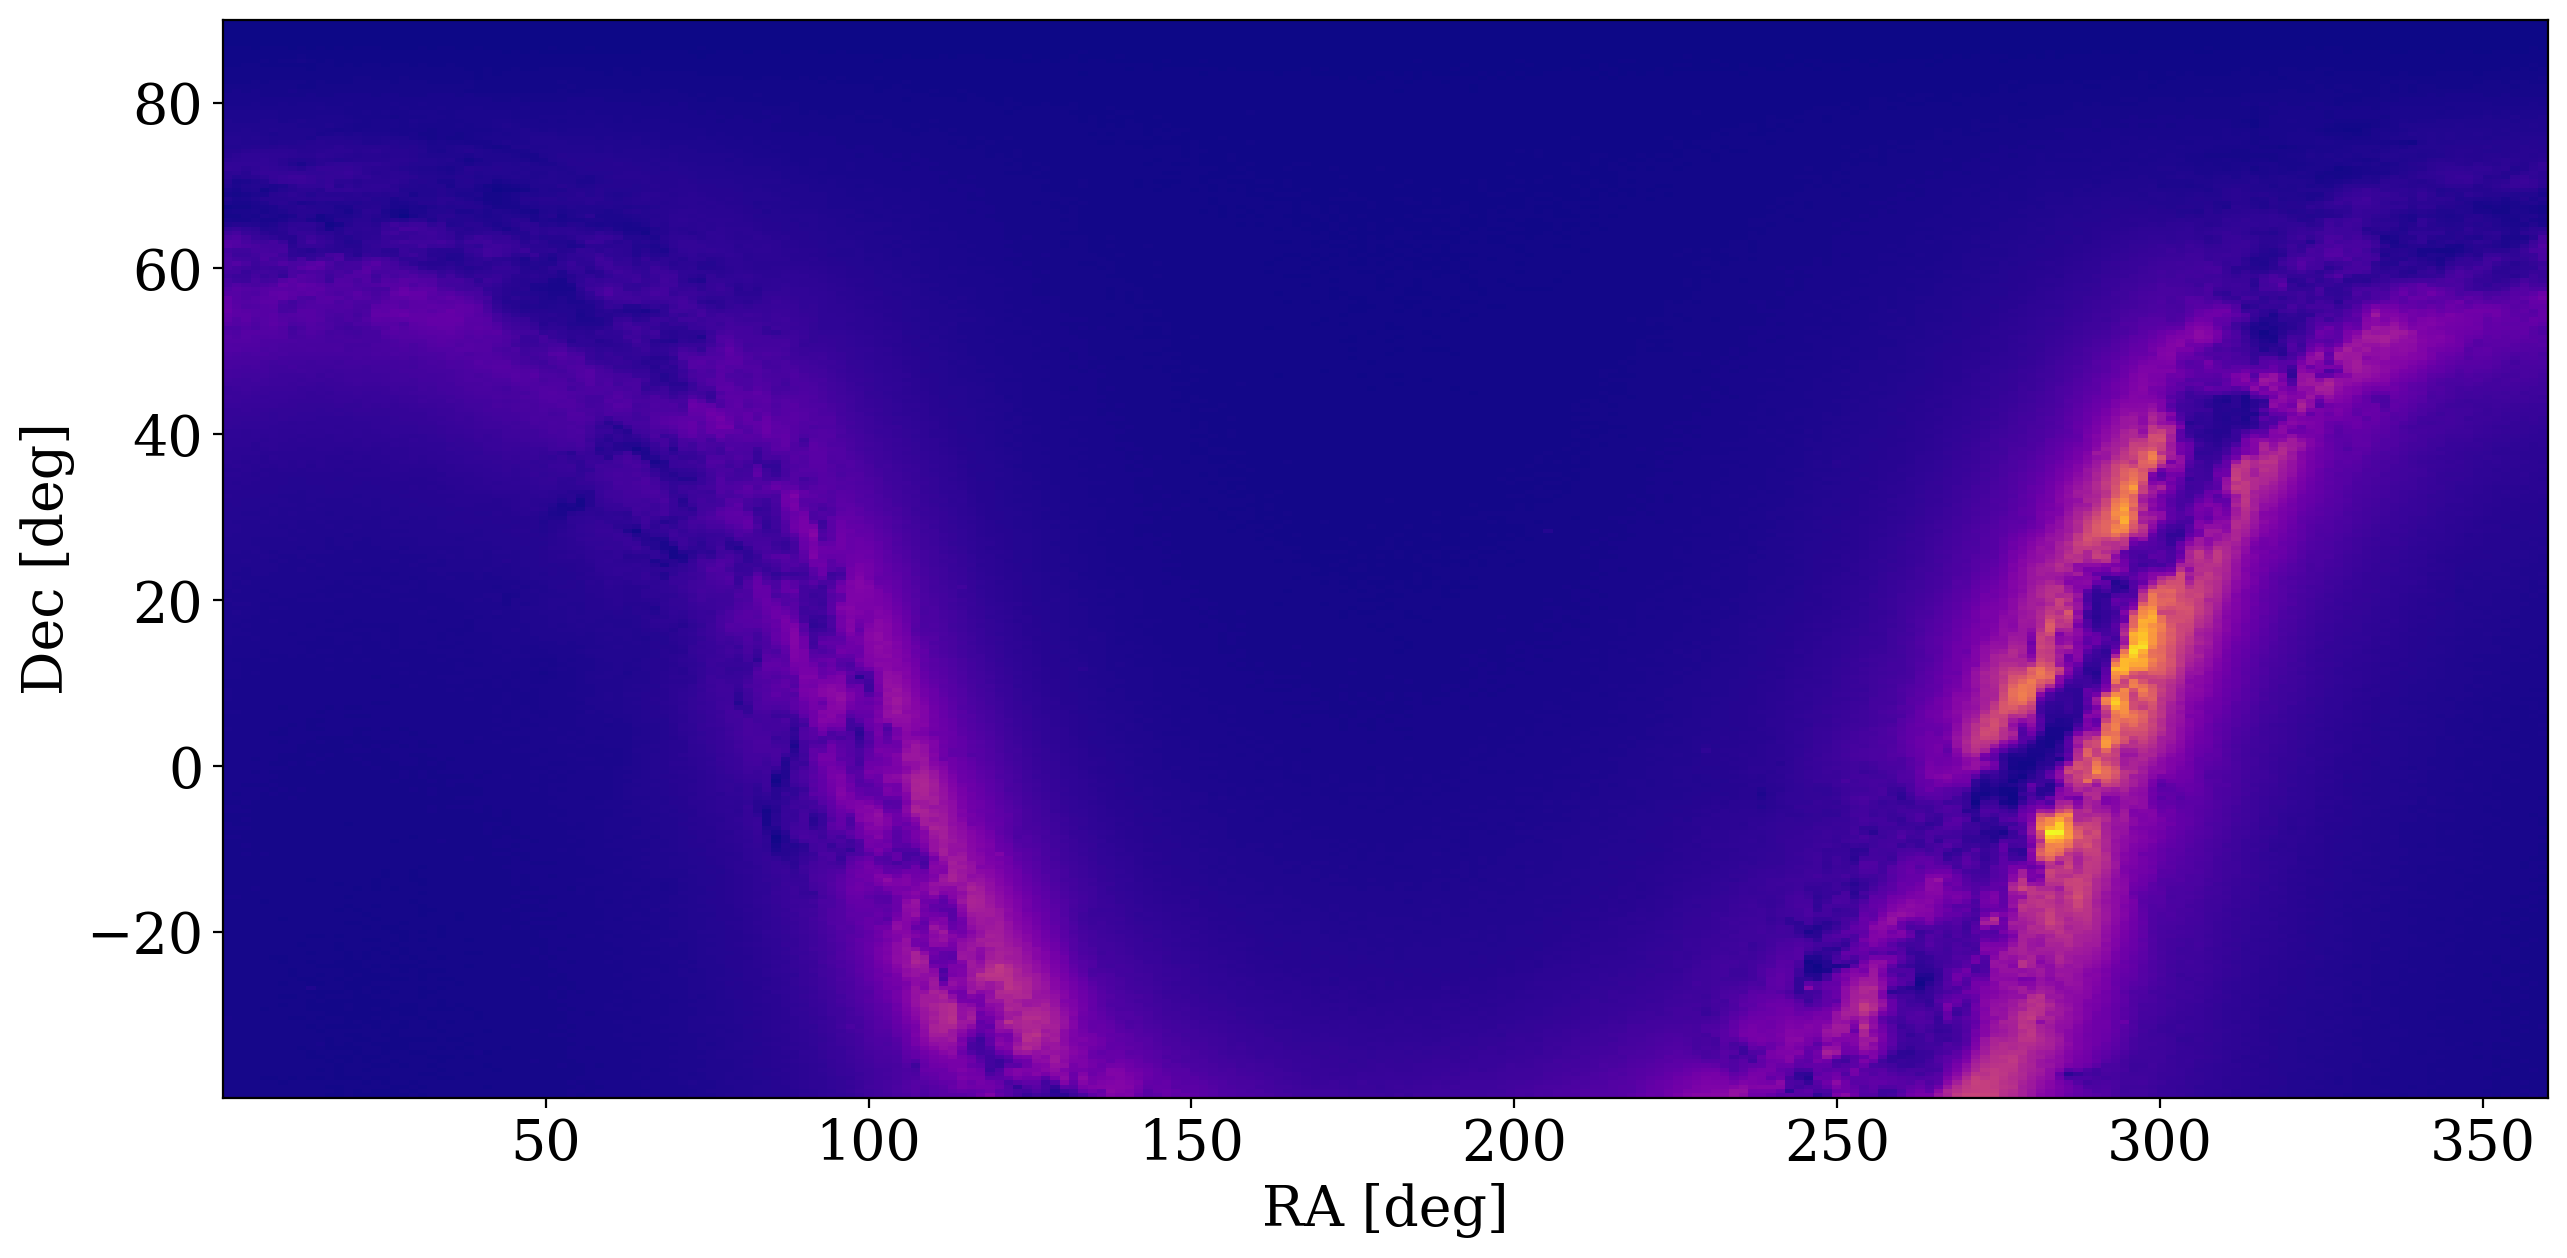

In [11]:
# let's visualize all sky coverage
plt.figure(figsize=(15,7))
_ = plt.hist2d(star_horse['RA_ICRS'],
               star_horse['DE_ICRS'], bins=(250, 250), cmap='plasma')
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")

In [13]:
# Completed on Feb 19th
#%%time # started Feb 19 @ 2PM

# StarHorse into hipscat
#star_horse_cat = lsdb.from_dataframe(
#    star_horse,
#    catalog_name="StarHorse",
#    catalog_type="object",
#    lowest_order=5, 
#    highest_order=8, 
#    ra_column="RA_ICRS", 
#    dec_column="DE_ICRS", 
#    threshold=1_000_000)

CPU times: user 47min 2s, sys: 11min 57s, total: 58min 59s
Wall time: 59min 3s


In [16]:
#@%%time
# Save it to disk in HiPSCat format
#star_horse_cat.to_hipscat("/nvme/users/atzanida/tmp/starhorse_hips")
# Stored on Feb. 19

CPU times: user 8min 9s, sys: 1min 58s, total: 10min 7s
Wall time: 4min 42s


In [15]:
%%time
star_horse_cat = lsdb.read_hipscat("/nvme/users/atzanida/tmp/starhorse_hips")

CPU times: user 725 ms, sys: 106 ms, total: 830 ms
Wall time: 826 ms


In [17]:
%%time
# Crossmatch ZTF object to StarHorse Catalog
all_combo = star_horse_cat.crossmatch(ztf)

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:100: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 3.06 s, sys: 193 ms, total: 3.25 s
Wall time: 3.25 s


In [18]:
%%time
all_combo._ddf.head(5, npartitions=2)

CPU times: user 1.53 s, sys: 861 ms, total: 2.39 s
Wall time: 2.08 s


,Source_StarHorse,RA_ICRS_StarHorse,DE_ICRS_StarHorse,teff50_StarHorse,logg50_StarHorse,met50_StarHorse,dist50_StarHorse,fidelity_StarHorse,GMAG0_StarHorse,BP-RP0_StarHorse,...,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
12482248704,4295806720,44.996155,0.005615,5452.18,4.557970,-0.486325,2.280843,1.0,5.611737,0.896228,...,364,381,18,18.143208,17.569102,17.373423,3,0,0,0.000011
116614234112,38655544960,45.004978,0.019880,4933.98,4.638439,-0.309177,0.312808,1.0,6.318658,1.120751,...,371,387,18,14.916993,14.028394,13.727368,3,0,0,0.000034
751493447680,343597448960,44.963896,0.043595,5167.75,4.535853,-0.165656,2.486011,1.0,5.718467,1.044423,...,359,379,17,18.873053,18.022047,17.742535,3,0,0,0.000019
1131799379968,549755818112,45.048282,0.048254,5411.06,4.525750,-0.147021,0.603629,1.0,5.369191,0.885475,...,381,391,18,15.716422,14.905342,14.602479,3,0,0,0.000014
1702816120832,828929527040,45.023620,0.068419,4754.50,4.653356,-0.437974,0.786489,1.0,6.655048,1.194384,...,380,393,18,17.505628,16.473952,16.109312,3,0,0,0.000007


## Make a CMD of FGK Dwarfs

/tmp/ipykernel_120484/1060391087.py:10: RuntimeWarning: divide by zero encountered in log10
  J_log = np.log10(J)


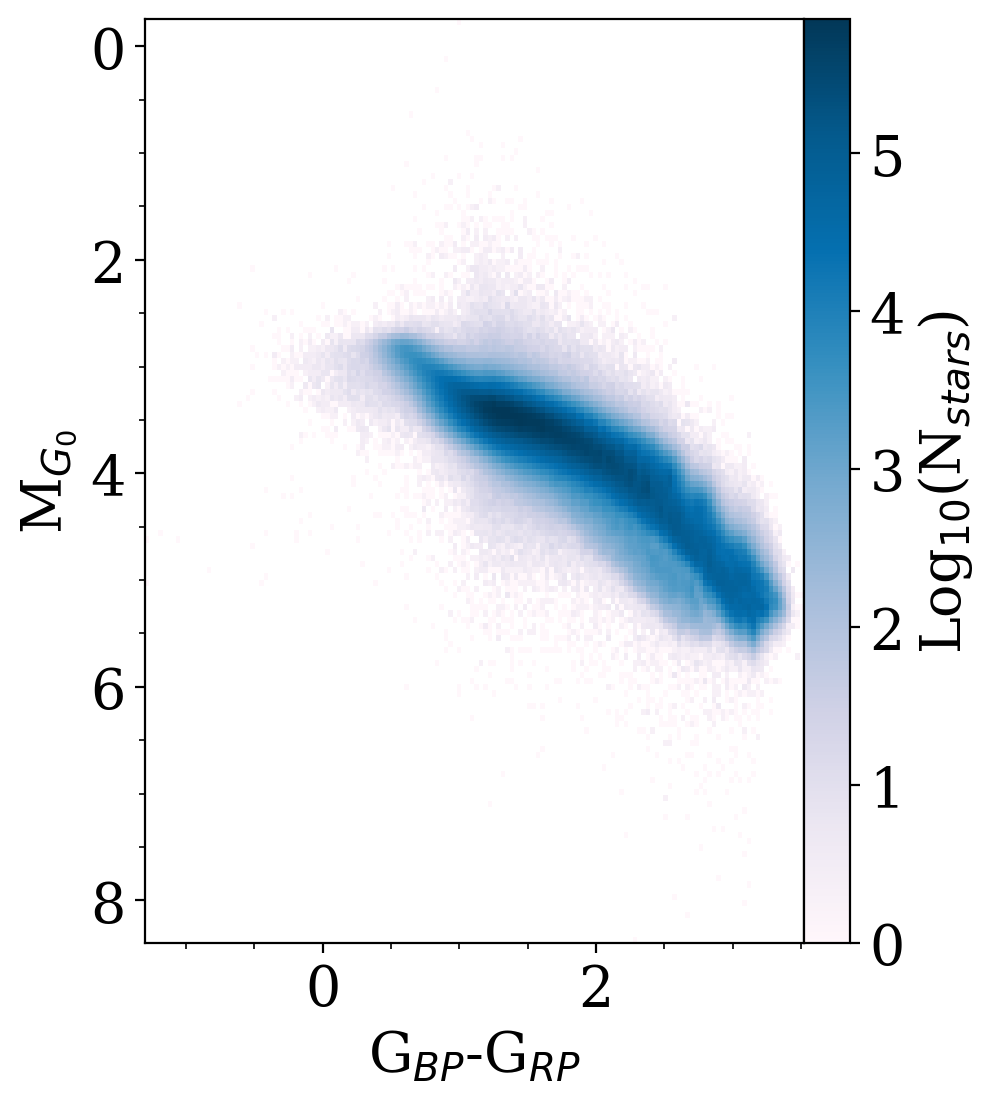

In [67]:
# Create a mask for NaN values
mask = ~np.isnan(star_horse['BP-RP0']) & ~np.isnan(star_horse['GMAG0'])

# Use the mask to select only non-NaN values
J, xedges, yedges = np.histogram2d(star_horse['BP-RP0'][mask],
                                   star_horse['GMAG0'][mask], 
                                   bins=(150, 150))

J_log = np.log10(J)

plt.figure(figsize=(5, 6))
# Plot the log-scaled imshow
plt.imshow(J_log,
           extent=[xedges[0],
                   xedges[-1],
                   yedges[0], 
                   yedges[-1]], 
           aspect='auto', origin='lower', cmap='PuBu')

plt.xlabel("G$_{BP}$-G$_{RP}$")
plt.ylabel("M$_{G_0}$")
plt.ylim(plt.ylim()[::-1])
plt.colorbar(pad=0.00001, label='Log$_{10}$(N$_{stars}$)')
plt.minorticks_on()

## Initialize TAPE

In [24]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper
pd.options.mode.chained_assignment = None

# Initialize an Ensemble
ens = Ensemble(n_workers=15, threads_per_worker=1)
ens.client_info()

In [27]:
%%time 
# Let's compute the all-combo table!!
all_combo_computed = all_combo.compute()

CPU times: user 2h 20min 9s, sys: 2h 7min 56s, total: 4h 28min 6s
Wall time: 17min 47s


## Understanding and Cutting the Stellar Locus

In [353]:
qr = (all_combo_computed['ps1_gMeanPSFMag_ztf_dr14'] > -999) & \
        (all_combo_computed['ps1_rMeanPSFMag_ztf_dr14'] > -999) & \
(all_combo_computed['ps1_iMeanPSFMag_ztf_dr14'] > -999) & \
(all_combo_computed['ps1_gMeanPSFMag_ztf_dr14']!=np.nan) & \
(all_combo_computed['ps1_rMeanPSFMag_ztf_dr14']!=np.nan) & \
(all_combo_computed['ps1_iMeanPSFMag_ztf_dr14']!=np.nan) & \
(all_combo_computed['_DIST'] < 0.001)

In [354]:
ff2 = all_combo_computed[qr]

gr = ff2['ps1_gMeanPSFMag_ztf_dr14']-ff2['ps1_rMeanPSFMag_ztf_dr14']
ri = ff2['ps1_rMeanPSFMag_ztf_dr14']-ff2['ps1_iMeanPSFMag_ztf_dr14']

In [358]:
J, xx, yy = np.histogram2d(gr, ri, bins=(750, 750))

/tmp/ipykernel_105059/3874677837.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(J.T), origin='lower',


Text(0, 0.5, '(r-i)$_{PS1}$')

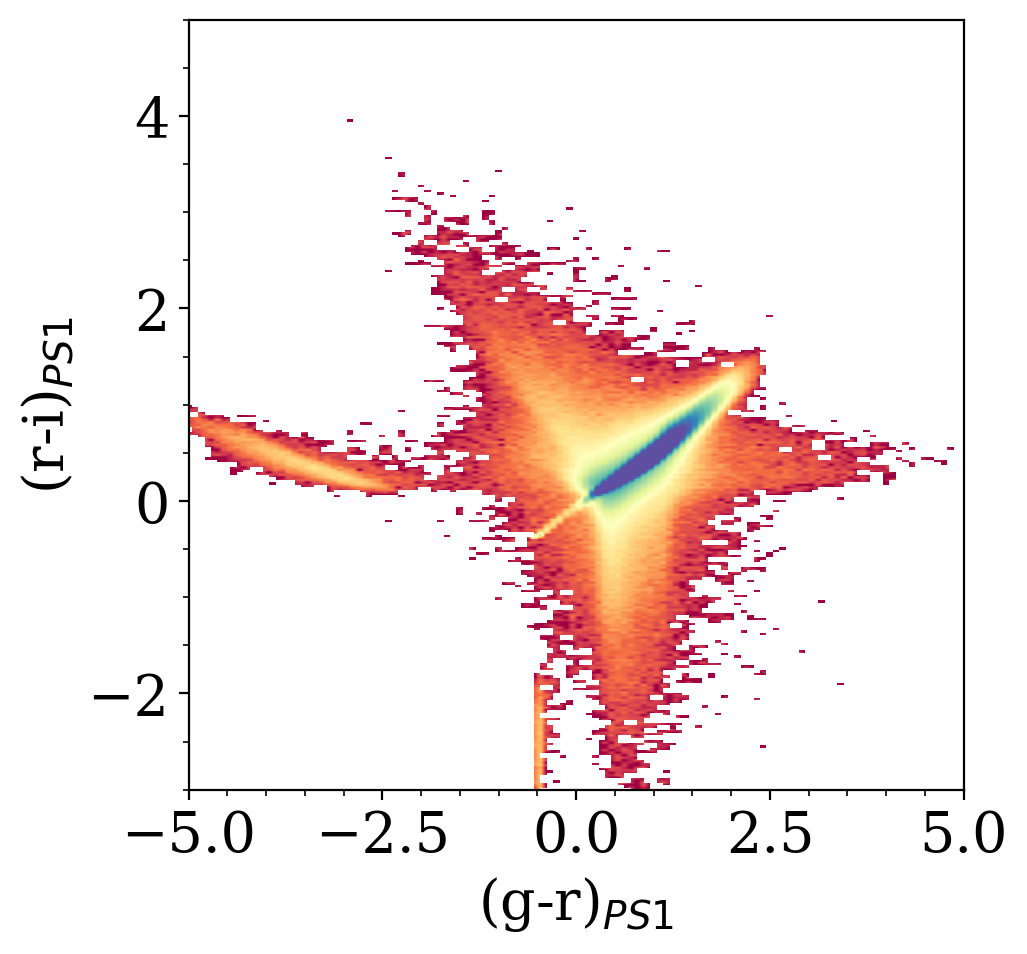

In [366]:
plt.figure(figsize=(5,5))
plt.imshow(np.log10(J.T), origin='lower', 
          extent=[xx[0], xx[-1], yy[0], yy[-1]], 
          aspect='auto', 
          vmin=0, vmax=5, 
          cmap='Spectral')
plt.xlim(-5, 5)
plt.ylim(-3, 5)
plt.minorticks_on()
plt.xlabel("(g-r)$_{PS1}$")
plt.ylabel("(r-i)$_{PS1}$")

# what are all these systematics and why isn't it as clean?

In [367]:
from scipy.stats import binned_statistic_2d

In [418]:
Hh = binned_statistic_2d(gr, ri, ff2['teff50_StarHorse'], 
                   bins=(450, 450),statistic='std')

Text(0, 0.5, '(r-i)$_{PS1}$')

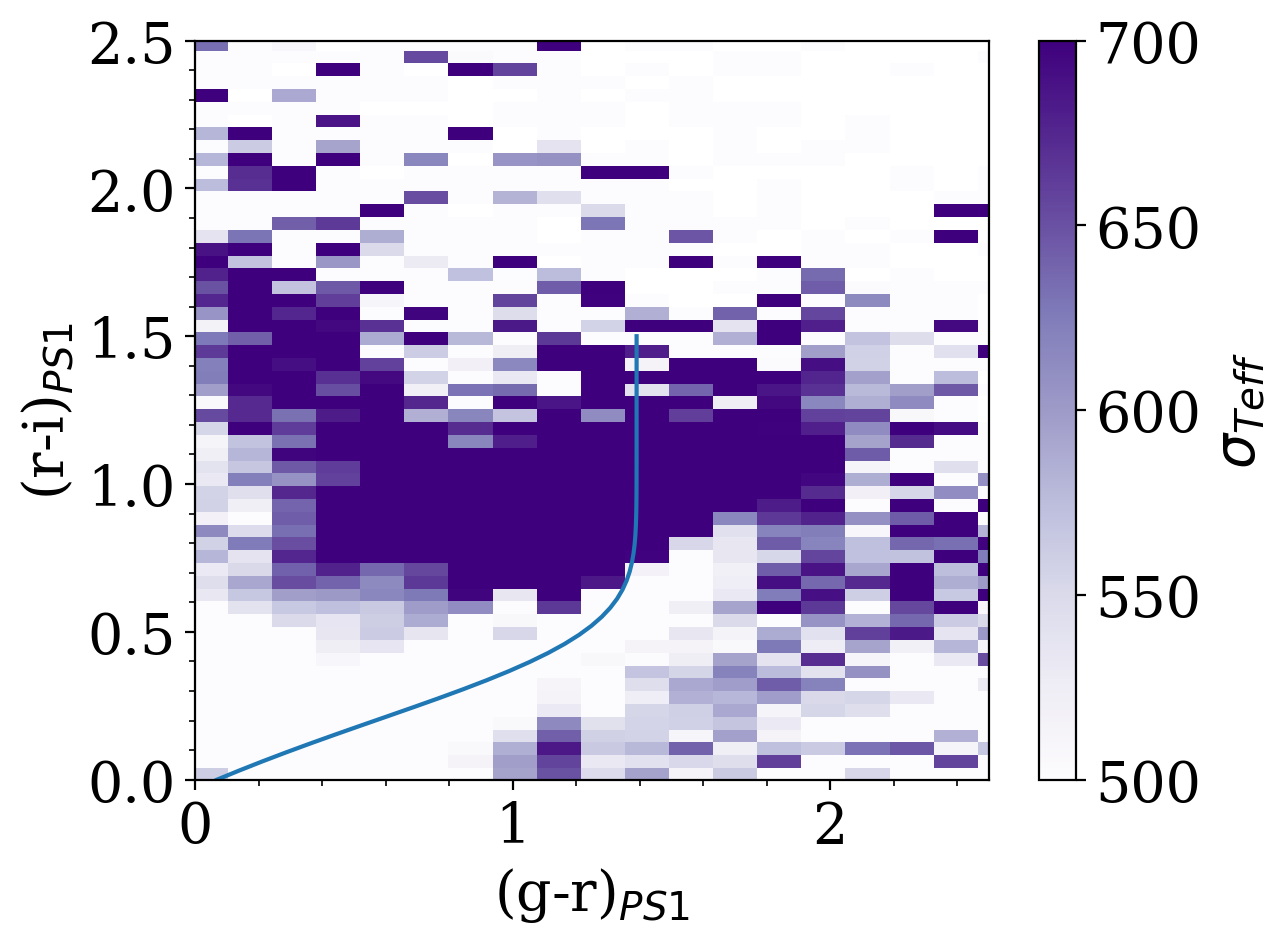

In [422]:
# classic degeneracies in temperature and overall extinction! 
plt.imshow((Hh[0].T), 
          origin='lower', 
          extent=[Hh[1][0], Hh[1][-1], Hh[2][0], Hh[2][-1]], 
          aspect='auto', 
          cmap="Purples", vmin=500, vmax=700)
plt.colorbar(label='$\sigma_{Teff}$')
plt.xlim(-5, 5)
plt.ylim(-3, 5)


plt.xlim(0, 2.5)
plt.ylim(0, 2.5)


xx_lin = np.linspace(0, 1.5)
polynom = lambda ri: 1.39*(1-np.exp(-4.9 * ri**3 - 2.45*ri**2 - 1.68*ri - 0.050))
plt.plot(polynom(xx_lin), xx_lin)

plt.minorticks_on()
plt.xlabel("(g-r)$_{PS1}$")
plt.ylabel("(r-i)$_{PS1}$")

In [345]:
xx_lin = np.linspace(0, 1.5)
polynom = lambda ri: 1.39*(1-np.exp(-4.9 * ri**3 - 2.45*ri**2 - 1.68*ri - 0.050))
plt.plot(polynom(xx_lin), xx_lin)

/tmp/ipykernel_105059/3233261370.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(J.T), origin='lower',


Text(0, 0.5, 'r-i')

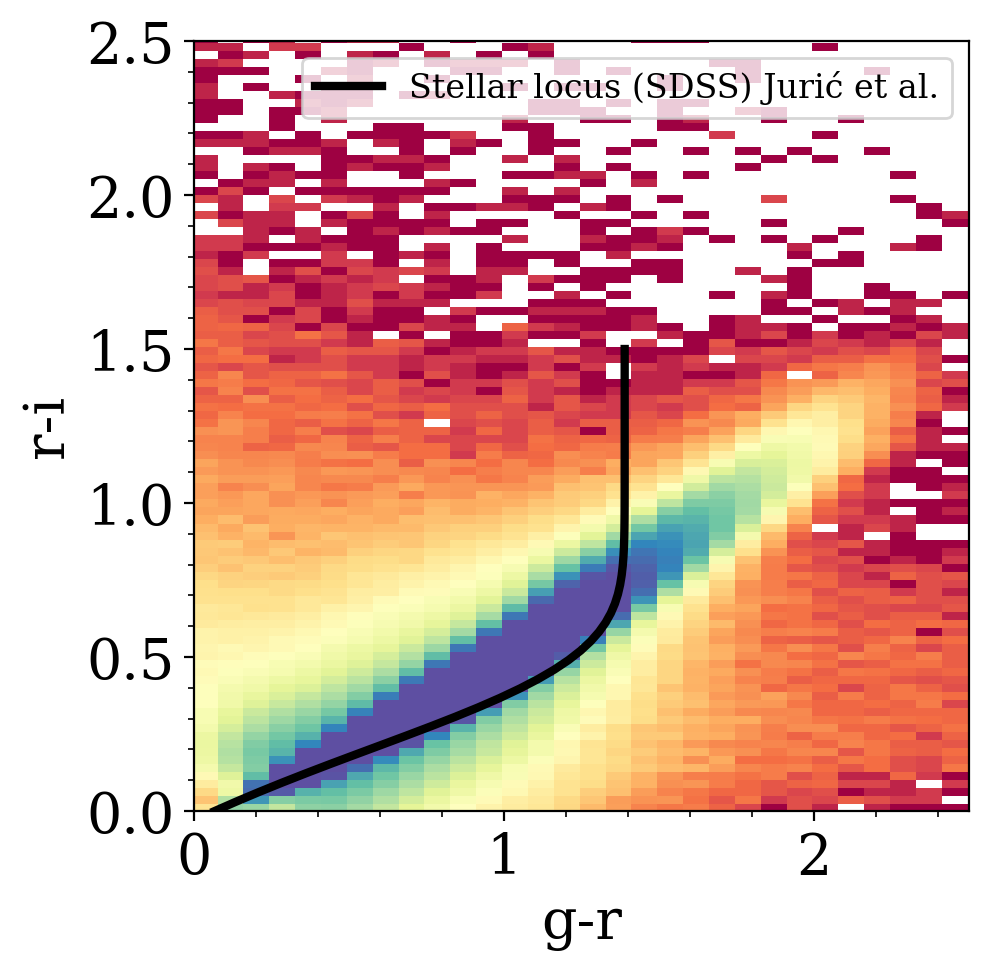

In [434]:
plt.figure(figsize=(5,5))
plt.imshow(np.log10(J.T), origin='lower', 
          extent=[xx[0], xx[-1], yy[0], yy[-1]], 
          aspect='auto', 
          vmin=0, vmax=5, 
          cmap='Spectral')

plt.plot(polynom(xx_lin), xx_lin, 
        color='k', lw=3, 
        label='Stellar locus (SDSS) Jurić et al.')

plt.legend(fontsize=12)

plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.minorticks_on()
plt.xlabel("g-r")
plt.ylabel("r-i")

## Make Polygon Selection

In [282]:
from matplotlib.patches import Polygon

In [442]:
xx_lin = np.linspace(0.2, 1.2)

In [443]:
# Vorticies of locus
poly_s = pd.DataFrame()
poly_s['x_var'] = [xx_lin[0], xx_lin[0], xx_lin[-1], xx_lin[-1]]
poly_s['y_var'] = [min(ls1), min(ls2), max(ls2), max(ls1)]
POLY = Polygon(poly_s)

In [436]:
# Data to pandas frame for cutting
data_s = pd.DataFrame()
data_s['x_var'] = gr
data_s['y_var'] = ri

In [444]:
# cut and select!
Q2 = POLY.contains_points(data_s)

In [445]:
print (f"Number of sources: {len(Q2[Q2==True])}")

Number of sources: 83062207


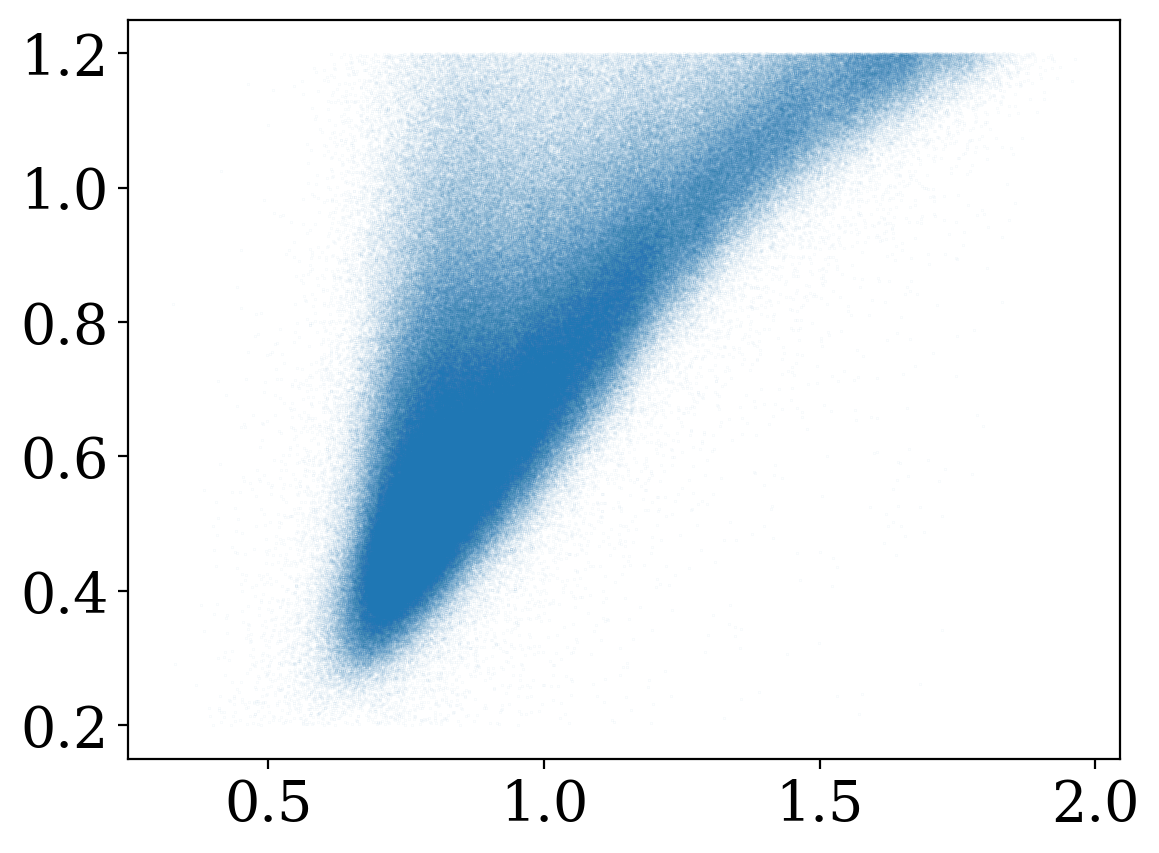

In [446]:
plt.scatter(ff2[Q2]['BP-RP0_StarHorse'][0:1_000_000],
           gr[Q2][0:1_000_000], s=0.0001)

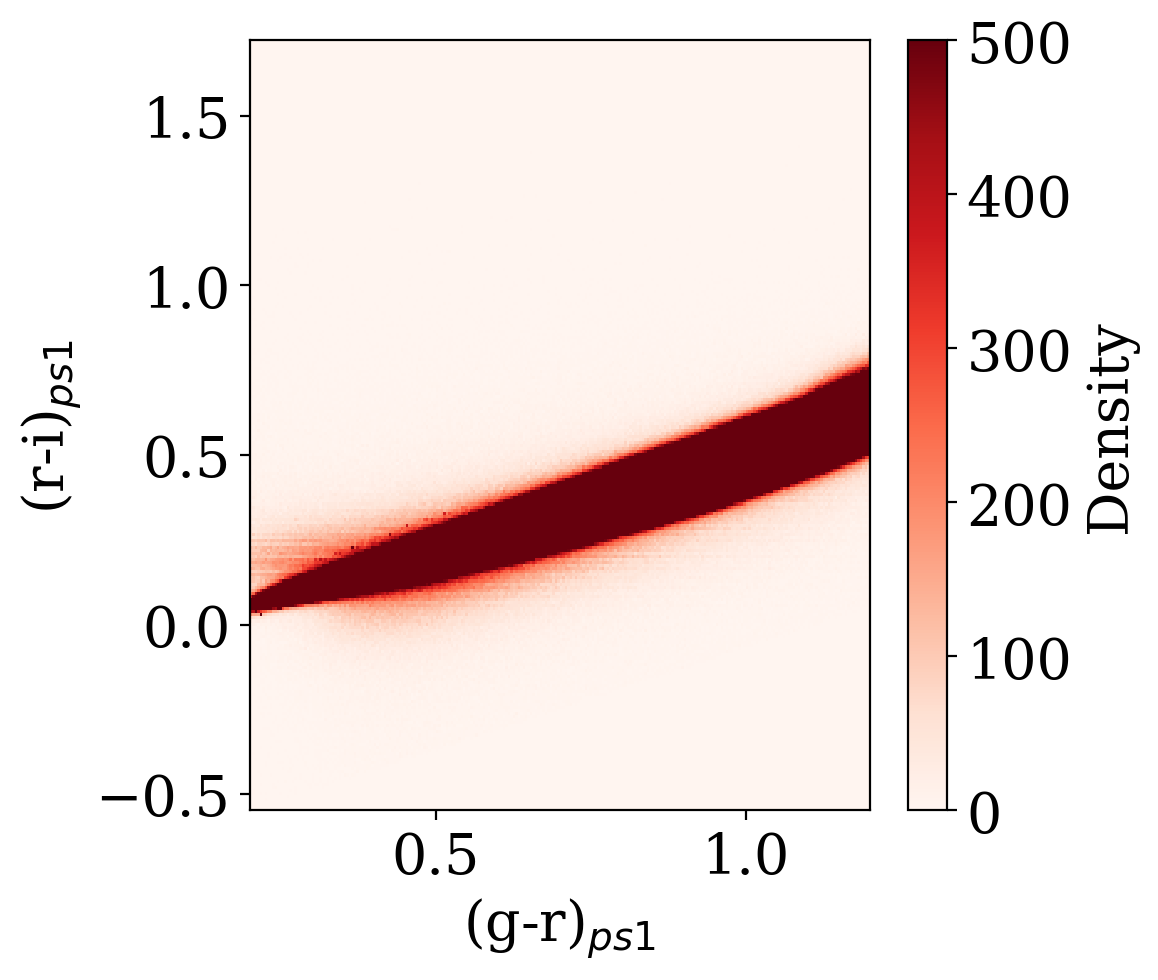

In [450]:
plt.figure(figsize=(5,5))
_ = plt.hist2d(gr[Q2], ri[Q2], bins=(250, 250), vmin=0, vmax=500, 
              cmap='Reds')
plt.xlabel("(g-r)$_{ps1}$")
plt.ylabel("(r-i)$_{ps1}$")
plt.colorbar(label="Density")

In [464]:
my_final_cut = ff2[Q2] # final FGK dwarf selection for the moment!

## Another Selection

In [473]:
q_ztf_quality = (my_final_cut['nobs_g_ztf_dr14'] > 250) & \
(my_final_cut['nobs_r_ztf_dr14']>250)

In [474]:
my_final_cut_1 = my_final_cut[q_ztf_quality]

In [475]:
print (f"Number of good FGK dwarf candidates: {len(my_final_cut_1)}")

Number of good FGK dwarf candidates: 49304835


In [477]:
len(np.unique(my_final_cut_1['ps1_objid_ztf_dr14']))

49304475

In [485]:
my_final_cut_1.keys()

Index(['Source_StarHorse', 'RA_ICRS_StarHorse', 'DE_ICRS_StarHorse',
       'teff50_StarHorse', 'logg50_StarHorse', 'met50_StarHorse',
       'dist50_StarHorse', 'fidelity_StarHorse', 'GMAG0_StarHorse',
       'BP-RP0_StarHorse', 'Norder_StarHorse', 'Dir_StarHorse',
       'Npix_StarHorse', 'ps1_objid_ztf_dr14', 'ra_ztf_dr14', 'dec_ztf_dr14',
       'ps1_gMeanPSFMag_ztf_dr14', 'ps1_rMeanPSFMag_ztf_dr14',
       'ps1_iMeanPSFMag_ztf_dr14', 'nobs_g_ztf_dr14', 'nobs_r_ztf_dr14',
       'nobs_i_ztf_dr14', 'mean_mag_g_ztf_dr14', 'mean_mag_r_ztf_dr14',
       'mean_mag_i_ztf_dr14', 'Norder_ztf_dr14', 'Dir_ztf_dr14',
       'Npix_ztf_dr14', '_DIST'],
      dtype='object')

In [ ]:
%%time
final_tab = lsdb.from_dataframe(my_final_cut_1,
                                ra_column="RA_ICRS_StarHorse", 
                                dec_column="DE_ICRS_StarHorse", 
                                threshold=1_000_000)

In [497]:
#%%time
#final_tab.to_hipscat("/nvme/users/atzanida/tmp/sample_final_starhorse_hips")
# stored on March 11th, 2024

In [489]:
%%time
_sources = final_tab.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/join_catalog_data.py:195: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 2min 22s, sys: 12.4 s, total: 2min 34s
Wall time: 2min 47s


In [4]:
len(final_tab)

NameError: name 'final_tab' is not defined